In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
sns.set_style("darkgrid")

In [205]:
import warnings
warnings.filterwarnings('ignore')

In [142]:
raw_data = pd.read_csv("./pitch_project_data.csv")

In [297]:
conn = sqlite3.connect('elo.db')
curr = conn.cursor()

query = '''
SELECT key_mlbam FROM player_id WHERE 
name_first = ? 
AND name_last = ?
AND (? >= pro_played_first OR pro_played_first = '')
AND (? <= pro_played_last OR pro_played_last = '');
'''
names = []
i = 0
for r,s,t,u in zip(raw_data["firstName"], raw_data["lastName"], raw_data["year"], raw_data["year"]):
    names.append(curr.execute(query,(r,s,t,u)).fetchone())
    i+=1
    if i % 1000 == 0:
        print(i // 1000)

mlbam_ids = []
for n in names:
    # Exclude missing or duplicate mlbam ids
    if n is None:
        mlbam_ids.append(-1)
    else:
        a = None
        for i in n:
            if i != '':
                a = int(i)
                break
        if a is not None:
            mlbam_ids.append(a)
        else:
            mlbam_ids.append(-1)
        
raw_data["mlbam_id"] = np.array(mlbam_ids, dtype=np.int32)
raw_data.to_csv('./elo_pitcher_data.csv')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


In [85]:
conn = sqlite3.connect('elo.db')
curr = conn.cursor()

raw_data = pd.read_csv('./elo_pitcher_data.csv')
clean_data = raw_data[np.logical_and(raw_data["mlbam_id"] != -1,raw_data["year"] >= 2006)][["year","level","teamName","mlbam_id","bcubeID","milb_exp","draft_round","org_top10_post","ba100_post"]]
clean_data = clean_data[["year","bcubeID","mlbam_id","milb_exp","draft_round","org_top10_post","ba100_post"]].groupby(["year","bcubeID"]).mean()
clean_data["draft_round_cat"] = [x if x <= 5 else 0 for x in clean_data["draft_round"]]
clean_data = pd.concat([clean_data, pd.get_dummies(clean_data["draft_round_cat"], prefix = "draft_round_cat")], axis = 1)

org_top10_last_year, ba_100_post_last_year, elo = [], [], []
for year, bcubeID in clean_data.index:
    if year > 2006 and (year - 1,bcubeID) in clean_data.index:
        org_top10_last_year.append(clean_data.loc[(year - 1,bcubeID)]["org_top10_post"])
        ba_100_post_last_year.append(clean_data.loc[(year - 1,bcubeID)]["ba100_post"])
    else:
        org_top10_last_year.append(0)
        ba_100_post_last_year.append(0)
clean_data.reset_index(inplace = True)
for year, mlbam_id in zip(clean_data["year"].values, clean_data["mlbam_id"].values):
    query = '''
    SELECT elo FROM elo_year_end WHERE mlbam_id = {} AND date = "{}-12-31"
    '''.format(mlbam_id, year)
    result = curr.execute(query).fetchone()
    if result is not None and result[0] != '':
        elo.append(float(result[0]))
    else:
        elo.append(np.nan)
    
clean_data["org_top10_post_last_year"] = org_top10_last_year
clean_data["ba100_post_last_year"] = ba_100_post_last_year
clean_data["elo"] = elo
clean_data = clean_data[clean_data["year"] >= 2007]
clean_data.head()

,year,bcubeID,mlbam_id,milb_exp,draft_round,org_top10_post,ba100_post,draft_round_cat,draft_round_cat_0,draft_round_cat_1,draft_round_cat_2,draft_round_cat_3,draft_round_cat_4,draft_round_cat_5,org_top10_post_last_year,ba100_post_last_year,elo
2300,2007,25,407193,8,14,0,0,0,1,0,0,0,0,0,0,0,100.140915
2301,2007,33,452298,7,13,0,0,0,1,0,0,0,0,0,0,0,99.983596
2302,2007,82,453483,9,23,0,0,0,1,0,0,0,0,0,0,0,99.996701
2303,2007,93,430636,8,26,0,0,0,1,0,0,0,0,0,0,0,99.846034
2304,2007,96,432934,7,3,0,0,3,0,0,0,1,0,0,0,0,99.916575


In [86]:
clean_data.to_csv('./elo_pitcher_data_clean.csv')

In [258]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import confusion_matrix, average_precision_score

clean_data = pd.read_csv('./elo_pitcher_data_clean.csv').dropna()
features = [
    "milb_exp", 
    "draft_round_cat_0",
    "draft_round_cat_1", 
    "draft_round_cat_2", 
    "draft_round_cat_3",
    "draft_round_cat_4",
    "draft_round_cat_5",
    "org_top10_post_last_year",
    "ba100_post_last_year",
    "elo"
]

baseline_features = [
    "milb_exp", 
    "draft_round_cat_0",
    "draft_round_cat_1", 
    "draft_round_cat_2", 
    "draft_round_cat_3",
    "draft_round_cat_4",
    "draft_round_cat_5",
    "org_top10_post_last_year",
    "ba100_post_last_year"
]

response = ["org_top10_post"]

np.random.seed(7)
X,y = clean_data[features], clean_data[response]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size = 0.125, stratify = y_train)

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05]),
 <a list of 6 Text yticklabel objects>)

<Figure size 720x432 with 0 Axes>

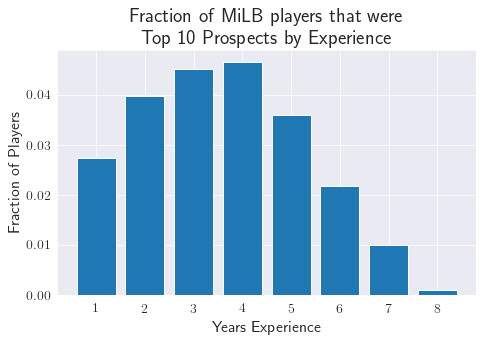

In [259]:
plt.rc('text', usetex = True)
plt.figure(figsize = (10,6))
num_top10 = [y_train[X_train["milb_exp"] == i]["org_top10_post"].sum() for i in range(1,9)]
num_not_top10 = [(1 - y_train)[X_train["milb_exp"] == i]["org_top10_post"].sum() for i in range(1,9)]

plt.figure(figsize = (7.5,4.5))
plt.bar(np.arange(1,9), [n / (n + n_) for n,n_ in zip(num_top10, num_not_top10)])
plt.title("Fraction of MiLB players that were\nTop 10 Prospects by Experience", size = 20)
plt.xlabel("Years Experience", size = 16)
plt.xticks(size = 14)
plt.ylabel("Fraction of Players", size = 16)
plt.yticks(size = 14)

Text(0.5, 1.1, 'Number of Players in Draft Categories')

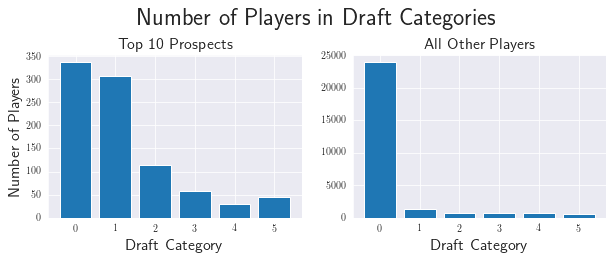

In [260]:
plt.rc('text', usetex = True)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,3))

num_top10 = [y_train[X_train["draft_round_cat_" + str(i)] == 1]["org_top10_post"].sum() for i in range(6)]
ax[0].bar(np.arange(6), num_top10)
ax[0].set_title("Top 10 Prospects", size = 16)
ax[0].set_xlabel("Draft Category", size = 16)
ax[0].set_ylabel("Number of Players", size = 16)
num_not_top10 = [(1 - y_train)[X_train["draft_round_cat_" + str(i)] == 1]["org_top10_post"].sum() for i in range(6)]
ax[1].bar(np.arange(6), num_not_top10)
ax[1].set_title("All Other Players", size = 16)
ax[1].set_xlabel("Draft Category", size = 16)
plt.suptitle("Number of Players in Draft Categories", y = 1.1, size = 24)

Text(0.5, 1.1, 'Number of Players Repeating Top 10 Appearance')

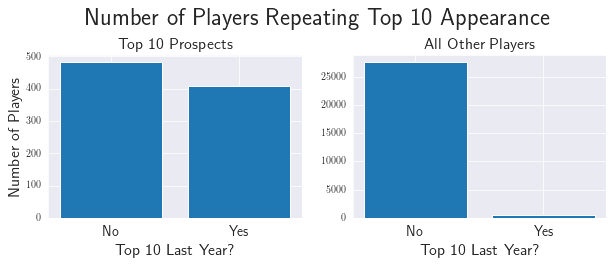

In [261]:
plt.rc('text', usetex = True)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,3))

num_top10 = [y_train[X_train["org_top10_post_last_year"] == i]["org_top10_post"].sum() for i in range(2)]
ax[0].bar(np.arange(2), num_top10)
ax[0].set_title("Top 10 Prospects", size = 16)
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(["No","Yes"], size = 14)
ax[0].set_xlabel("Top 10 Last Year?", size = 16)
ax[0].set_ylabel("Number of Players", size = 16)
num_not_top10 = [(1 - y_train)[X_train["org_top10_post_last_year"] == i]["org_top10_post"].sum() for i in range(2)]
ax[1].bar(np.arange(2), num_not_top10)
ax[1].set_title("All Other Players", size = 16)
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(["No","Yes"], size = 14)
ax[1].set_xlabel("Top 10 Last Year?", size = 16)
plt.suptitle("Number of Players Repeating Top 10 Appearance", y = 1.1, size = 24)

Text(0.5, 1.0, 'Distribution of Elo Scores')

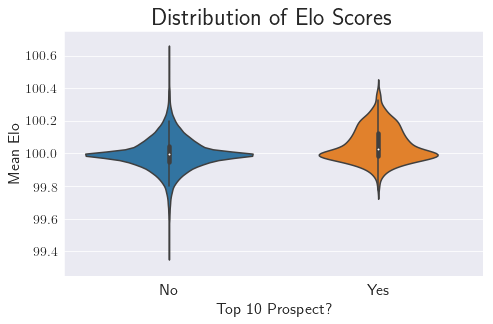

In [273]:
plt.rc('text', usetex = True)
plt.figure(figsize = (7.5,4.5))
sns.violinplot(x = "org_top10_post", y = "elo", data = pd.concat([X_train,y_train], axis = 1))
plt.ylim(99.25,100.75)
plt.xlabel("Top 10 Prospect?", size = 16)
plt.xticks(ticks = [0,1], labels = ["No","Yes"], size = 16)
plt.ylabel("Mean Elo", size = 16)
plt.yticks(size = 14)
plt.title("Distribution of Elo Scores", size = 24)

In [236]:
kyle_query = '''
select date, elo from elo where mlbam_id = 543294 and pos = 'P';
'''

almonte_query = '''
select date, elo from elo where mlbam_id = 622075 and pos = 'P';
'''

mejia_query = '''
select date, elo from elo where mlbam_id = 646301 and pos = 'P';
'''

conn = sqlite3.connect('elo.db')
curr = conn.cursor()

plot_elos_dict = {
    'Kyle Hendricks': pd.DataFrame(curr.execute(kyle_query).fetchall(), columns = ["date","elo"]),
    'Yency Almonte': pd.DataFrame(curr.execute(almonte_query).fetchall(), columns = ["date","elo"]),
    'Jefferson Mejia': pd.DataFrame(curr.execute(mejia_query).fetchall(), columns = ["date","elo"]),
}

Text(2016-06-01 00:00:00, 99.95, '$5.23$ ERA in $82.2$ IP')

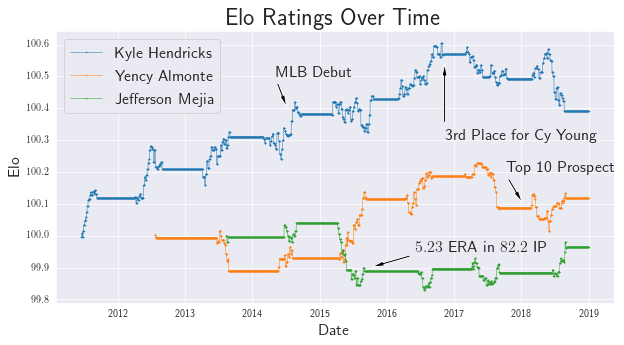

In [343]:
plt.figure(figsize = (10,5))
for name, df in plot_elos_dict.items():
    plt.plot_date(
        pd.to_datetime(df["date"]),
        df["elo"],
        '-o',
        markersize = 0.5,
        linewidth = 0.5,
        label = name
    )
plt.legend(prop = {'size':16})
plt.ylabel("Elo", size = 16)
plt.xlabel("Date", size = 16)
plt.title("Elo Ratings Over Time", size = 24)

plt.annotate(
    "MLB Debut", 
    (pd.to_datetime('2014-07-10'), 100.4), 
    (pd.to_datetime('2014-05-10'), 100.5),
    arrowprops = dict(facecolor='black', shrink=0.05, width = 2, headwidth = 5),
    size = 16
)

plt.annotate(
    "3rd Place for Cy Young", 
    (pd.to_datetime('2016-11-10'), 100.55), 
    (pd.to_datetime('2016-11-10'), 100.3),
    arrowprops = dict(facecolor='black', shrink=0.05, width = 2, headwidth = 5),
    size = 16
)

plt.annotate(
    "Top 10 Prospect", 
    (pd.to_datetime('2018-01-10'), 100.1), 
    (pd.to_datetime('2017-10-10'), 100.2),
    arrowprops = dict(facecolor='black', shrink=0.05, width = 2, headwidth = 5),
    size = 16
)

plt.annotate(
    "$5.23$ ERA in $82.2$ IP", 
    (pd.to_datetime('2015-10-01'), 99.9), 
    (pd.to_datetime('2016-06-01'), 99.95),
    arrowprops = dict(facecolor='black', shrink=0.05, width = 2, headwidth = 5),
    size = 16
)


In [313]:
X_train_baseline, X_dev_baseline = X_train[baseline_features], X_dev[baseline_features]
baseline = LR(class_weight = 'balanced').fit(X_train_baseline, y_train)
y_pred_baseline_dev = baseline.predict(X_dev_baseline)
y_pred_proba_baseline_dev = baseline.predict_proba(X_dev_baseline)[:,1]
print("Baseline Model Dev Accuracy: {:0.4f}".format(baseline.score(X_dev_baseline, y_dev)))
print("Baseline Model Dev AUPRC {:0.4f}".format(average_precision_score(y_dev, y_pred_proba_baseline_dev)))
print("Confusion Matrix:")  
print(confusion_matrix(y_dev, y_pred_baseline_dev))

Baseline Model Dev Accuracy: 0.9073
Baseline Model Dev AUPRC 0.3941
Confusion Matrix:
[[3655  351]
 [  32   95]]


In [314]:
clf = LR(random_state = 67, class_weight = 'balanced').fit(X_train, y_train)
y_pred_clf_dev = clf.predict(X_dev)
y_pred_proba_clf_dev = clf.predict_proba(X_dev)[:,1]
print("Model Dev Accuracy: {:0.4f}".format(clf.score(X_dev, y_dev)))
print("Model Dev AUPRC {:0.4f}".format(average_precision_score(y_dev, y_pred_proba_clf_dev)))
print("Confusion Matrix:")
print(confusion_matrix(y_dev, y_pred_clf_dev))

Model Dev Accuracy: 0.9073
Model Dev AUPRC 0.4141
Confusion Matrix:
[[3655  351]
 [  32   95]]


In [290]:
NBOOT_SAMPLES = 10000
improvements = []
for i in range(NBOOT_SAMPLES):
    if i % 1000 == 0:
        print(i)
    idx = np.random.randint(0, X_train.shape[0], size = X_train.shape[0])
    X_boot, y_boot = X_train.iloc[idx], y_train.iloc[idx]
    baseline_boot = LR(class_weight = 'balanced').fit(X_boot[baseline_features], y_boot)
    clf_boot = LR(class_weight = 'balanced').fit(X_boot, y_boot)
    
    baseline_boot_score = average_precision_score(y_dev, baseline_boot.predict_proba(X_dev[baseline_features])[:,1])
    clf_boot_score = average_precision_score(y_dev, clf.predict_proba(X_dev)[:,1])
    improvements.append(clf_boot_score - baseline_boot_score)
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]),
 <a list of 7 Text xticklabel objects>)

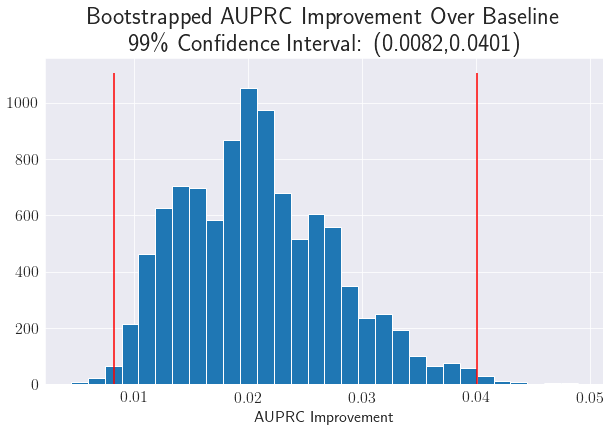

In [291]:
plt.rc('text', usetex = True)
plt.figure(figsize = (10,6))
plt.hist(improvements, bins = 30)
plt.vlines(np.percentile(improvements,[0.5,99.5]), *plt.ylim(), color = 'red')
plt.title("Bootstrapped AUPRC Improvement Over Baseline\n99\% Confidence Interval: ({:0.4f},{:0.4f})"\
          .format(*np.percentile(improvements,[0.5,99.5])), size = 24)
plt.xlabel("AUPRC Improvement", size = 16)
plt.yticks(size = 16)
plt.xticks(size = 16)

In [334]:
X_test_baseline = X_test[baseline_features]
y_pred_baseline = baseline.predict(X_test_baseline)
y_pred_proba_baseline = baseline.predict_proba(X_test_baseline)[:,1]
print("Baseline Model Dev Accuracy: {:0.4f}".format(baseline.score(X_test_baseline, y_test)))
print("Baseline Model Dev AUPRC {:0.4f}".format(average_precision_score(y_test, y_pred_proba_baseline)))
print("Confusion Matrix:")  
print(confusion_matrix(y_test, y_pred_baseline))

Baseline Model Dev Accuracy: 0.9073
Baseline Model Dev AUPRC 0.4136
Confusion Matrix:
[[7298  714]
 [  52  202]]


In [335]:
y_pred_clf = clf.predict(X_test)
y_pred_proba_clf = clf.predict_proba(X_test)[:,1]
print("Baseline Model Dev Accuracy: {:0.4f}".format(clf.score(X_test, y_test)))
print("Baseline Model Dev AUPRC {:0.4f}".format(average_precision_score(y_test, y_pred_proba_clf)))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_clf))

Baseline Model Dev Accuracy: 0.9073
Baseline Model Dev AUPRC 0.4234
Confusion Matrix:
[[7298  714]
 [  52  202]]


In [300]:
means_query = '''
select league, avg(elo) from elo where date = "2018-01-01" and pos = 'P' group by league
'''
means_result = curr.execute(means_query).fetchall()

In [302]:
dict(means_result)

{'aaa': 100.0338495890548,
 'aax': 100.03147322822652,
 'afa': 100.00563438422749,
 'afx': 99.99310089238952,
 'asx': 99.9879623673943,
 'mlb': 100.14760783062096,
 'rok': 99.9755597226349}

(array([ 99.9 ,  99.95, 100.  , 100.05, 100.1 , 100.15, 100.2 ]),
 <a list of 7 Text yticklabel objects>)

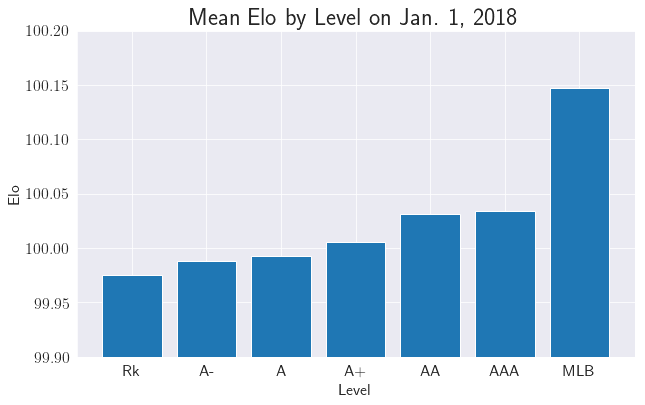

In [309]:
d = dict(means_result)
leagues = ['rok','asx','afx','afa','aax','aaa','mlb']

plt.figure(figsize = (10,6))
plt.bar(x = ["Rk","A-","A","A+","AA","AAA","MLB"],
        height = [d[l] for l in leagues])
plt.ylim(99.9,100.2)
plt.title("Mean Elo by Level on Jan. 1, 2018", size = 24)
plt.xlabel("Level", size = 16)
plt.xticks(size = 16)
plt.ylabel("Elo", size = 16)
plt.yticks(size = 16)

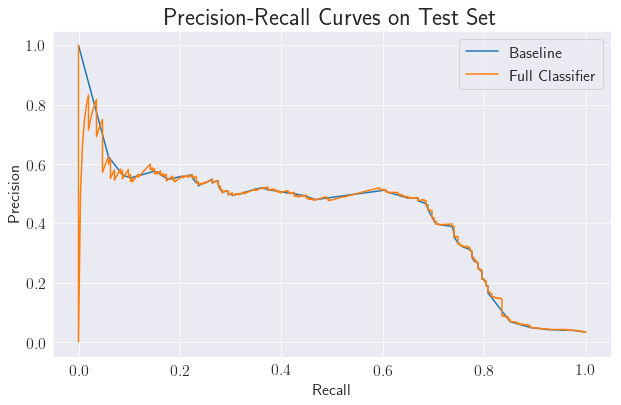

In [357]:
from sklearn.metrics import precision_recall_curve as prc
plt.figure(figsize = (10,6))
prc_base_test = prc(y_test, y_pred_proba_baseline)
prc_clf_test = prc(y_test, y_pred_proba_clf)
plt.plot(prc_base_test[1], prc_base_test[0], label = "Baseline")
plt.plot(prc_clf_test[1], prc_clf_test[0], label = "Full Classifier")
plt.title("Precision-Recall Curves on Test Set", size = 24)
plt.xlabel("Recall", size = 16)
plt.ylabel("Precision", size = 16)
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.legend(prop = {'size':16})